In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
#from datetime import datetime

df = pd.read_csv('gdrive/MyDrive/Colab Notebooks/o.csv')
df = df.mask(df.eq('None')).dropna()
print(df.head())

                  date   PM2.5    PM10      NO  ...    SO2    CO  Ozone  Wind speed
0  01-Jan-2019 - 00:00  334.57  505.57  122.51  ...  13.97  2.85  14.89        0.87
1  02-Jan-2019 - 00:00  357.48  546.75  127.59  ...  12.81  2.96  16.17        0.77
2  03-Jan-2019 - 00:00  371.11  525.56   89.04  ...  12.17  2.48  12.15        1.23
3  04-Jan-2019 - 00:00  314.30  473.55   82.87  ...  11.42  2.87   9.99        0.94
4  05-Jan-2019 - 00:00  310.04  464.17   70.41  ...  10.75  2.23  16.59        0.94

[5 rows x 11 columns]


In [5]:
train_dates = pd.to_datetime(df['date'])
print(train_dates.tail(15))

1020   2021-10-17
1021   2021-10-18
1022   2021-10-19
1023   2021-10-20
1024   2021-10-21
1025   2021-10-22
1026   2021-10-23
1027   2021-10-24
1028   2021-10-25
1029   2021-10-26
1030   2021-10-27
1031   2021-10-28
1032   2021-10-29
1033   2021-10-30
1034   2021-10-31
Name: date, dtype: datetime64[ns]


In [6]:
cols = list(df)[1:10]
print(cols)
df_for_training = df[cols].astype(float)

['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'SO2', 'CO', 'Ozone']


In [7]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized

scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [8]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

trainX = []
trainY = []
#testX  = []
#testY  = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

In [9]:
# Reformat input data into a shape: (n_samples x timesteps x n_features)

for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

In [10]:
trainX, trainY = np.array(trainX), np.array(trainY)

In [11]:
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

#print('testX shape == {}.'.format(testX.shape))
#print('testY shape == {}.'.format(testY.shape))

trainX shape == (947, 14, 9).
trainY shape == (947, 1).


In [12]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(0.01), metrics = ['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            18944     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 31,393
Trainable params: 31,393
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(trainX, trainY, epochs=5, batch_size=128, validation_split=0.1, verbose=2)

Epoch 1/5
7/7 - 3s - loss: 1.2861 - val_loss: 0.2807 - 3s/epoch - 494ms/step
Epoch 2/5
7/7 - 0s - loss: 0.8171 - val_loss: 0.1395 - 206ms/epoch - 29ms/step
Epoch 3/5
7/7 - 0s - loss: 0.7212 - val_loss: 0.1004 - 227ms/epoch - 32ms/step
Epoch 4/5
7/7 - 0s - loss: 0.5095 - val_loss: 0.1320 - 210ms/epoch - 30ms/step
Epoch 5/5
7/7 - 0s - loss: 0.4617 - val_loss: 0.0652 - 218ms/epoch - 31ms/step


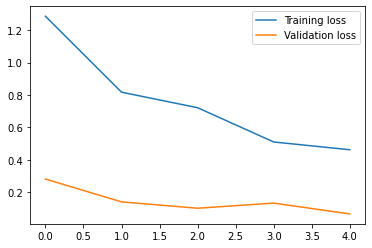

In [14]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [15]:
n_past = 16
n_days_for_prediction=15  #let us predict past 15 days

In [16]:
predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction).tolist()
print(predict_period_dates)

[Timestamp('2021-10-16 00:00:00', freq='D'), Timestamp('2021-10-17 00:00:00', freq='D'), Timestamp('2021-10-18 00:00:00', freq='D'), Timestamp('2021-10-19 00:00:00', freq='D'), Timestamp('2021-10-20 00:00:00', freq='D'), Timestamp('2021-10-21 00:00:00', freq='D'), Timestamp('2021-10-22 00:00:00', freq='D'), Timestamp('2021-10-23 00:00:00', freq='D'), Timestamp('2021-10-24 00:00:00', freq='D'), Timestamp('2021-10-25 00:00:00', freq='D'), Timestamp('2021-10-26 00:00:00', freq='D'), Timestamp('2021-10-27 00:00:00', freq='D'), Timestamp('2021-10-28 00:00:00', freq='D'), Timestamp('2021-10-29 00:00:00', freq='D'), Timestamp('2021-10-30 00:00:00', freq='D')]


In [17]:
prediction = model.predict(trainX[-n_days_for_prediction:])

In [18]:
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

In [19]:
# Timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

In [20]:
df_forecast = pd.DataFrame({'date':np.array(forecast_dates), 'PM2.5':y_pred_future})
df_forecast['date']=pd.to_datetime(df_forecast['date'])

In [21]:
original = df[['date', 'PM2.5']]
original['date']=pd.to_datetime(original['date'])
original = original.loc[original['date'] >= '2021-05-1']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


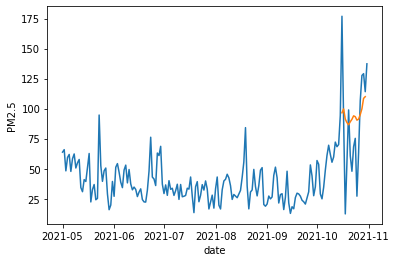

In [22]:
sns.lineplot(original['date'], original['PM2.5'])
sns.lineplot(df_forecast['date'], df_forecast['PM2.5'])

In [24]:
y_pred = model.predict(X_test)
model.evaluate(X_test,y_test)

ValueError: ignored

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")